In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

pro = ts.pro_api('6a556bff9d65d2106c76bbdaef29f4e690a049cc4d58266849c14d20')

In [8]:
#now = datetime.now()
#预测开始日期与训练结束日期重叠，目的训练只要取一次数据
#预测第二日的最高价，预测数据日期需要向后偏移一天；为了减少取数次数，预测时候删除第一日，训练数据删除最后一日

#预测数据开始、结束日期
#dt4 = (datetime.datetime.now() + datetime.timedelta(days=-1)) #.strftime("%Y%m%d")
_tscode='600754.SH'

sb = pro.stock_basic(ts_code=_tscode)
title = sb.loc[0]['symbol']+' '+sb.loc[0]['name']
print(title)
print("----------")

dt4 = datetime.datetime.now() #.strftime("%Y%m%d")
dt3 = dt4+datetime.timedelta(days=-8)
print(f'预测开始日期: {dt3.strftime("%Y-%m-%d")}')
print(f'预测结束日期: {dt4.strftime("%Y-%m-%d")}')

#训练、测试数据开始日期，结束日期
dt1 =  datetime.datetime.now()+ datetime.timedelta(days=-366)
dt2 = (dt4 + datetime.timedelta(days=-8)) #.strftime("%Y%m%d")
print("----------")
print(f'训练开始日期: {dt1.strftime("%Y-%m-%d")}')
print(f'训练结束日期: {dt2.strftime("%Y-%m-%d")}')



#日线行情
da = pro.daily(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
sub_da = da.drop(['change','pre_close','pct_chg','amount'],axis=1)
#每日指标
db = pro.daily_basic(ts_code=_tscode,start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))
sub_db = db.loc[:,['trade_date','turnover_rate','volume_ratio']]
#print(sub_db)

df1 = pd.merge(sub_da,sub_db,on=['trade_date'])

#港股通持股，取持股数量(股),您每分钟最多访问该接口2次
hh = pro.hk_hold(ts_code=_tscode,start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))
sub_hh = hh.loc[:,['trade_date','vol']]
sub_hh['vol'] = sub_hh['vol']/10000
#print(sub_hh)

#融资融券交易明细,取融资余额，融券余额
md = pro.margin_detail(ts_code=_tscode,start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))
sub_md = md.loc[:,['trade_date','rzye','rqye']]
sub_md['rzye'] = sub_md['rzye']/10000
sub_md['rqye'] = sub_md['rqye']/10000
#print(sub_md)

#df1 = dp.merge(df1,sub_hh,on=['trade_date'])
df1 = pd.merge(df1,sub_md,on=['trade_date'])
#print(df1)

#资金流向
mf = pro.moneyflow(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
sub_mf = mf.loc[:,['trade_date','net_mf_amount']]
df1 = pd.merge(df1,sub_mf,on=['trade_date'])
#print(df1)

X = df1[1:].drop(['ts_code','trade_date'],axis=1)
#print(X.columns)
#训练day+1 的最高价
y = df1[:-1]['high']
#print(X)


#有字段是NAN值 ，需要替换
X.fillna(0,inplace=True)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True)


600754 锦江酒店
----------
预测开始日期: 2021-02-09
预测结束日期: 2021-02-17
----------
训练开始日期: 2020-02-17
训练结束日期: 2021-02-09


               2-tailed        p-value
open           0.986659  2.534061e-153
high           0.993089  1.290056e-180
low            0.991247  8.440360e-171
close          0.994947  1.245688e-193
vol            0.171226   1.697957e-02
turnover_rate  0.171237   1.697226e-02
volume_ratio  -0.017895   8.044026e-01
rzye           0.470029   4.693592e-12
rqye           0.461719   1.233749e-11
net_mf_amount  0.091131   2.063253e-01


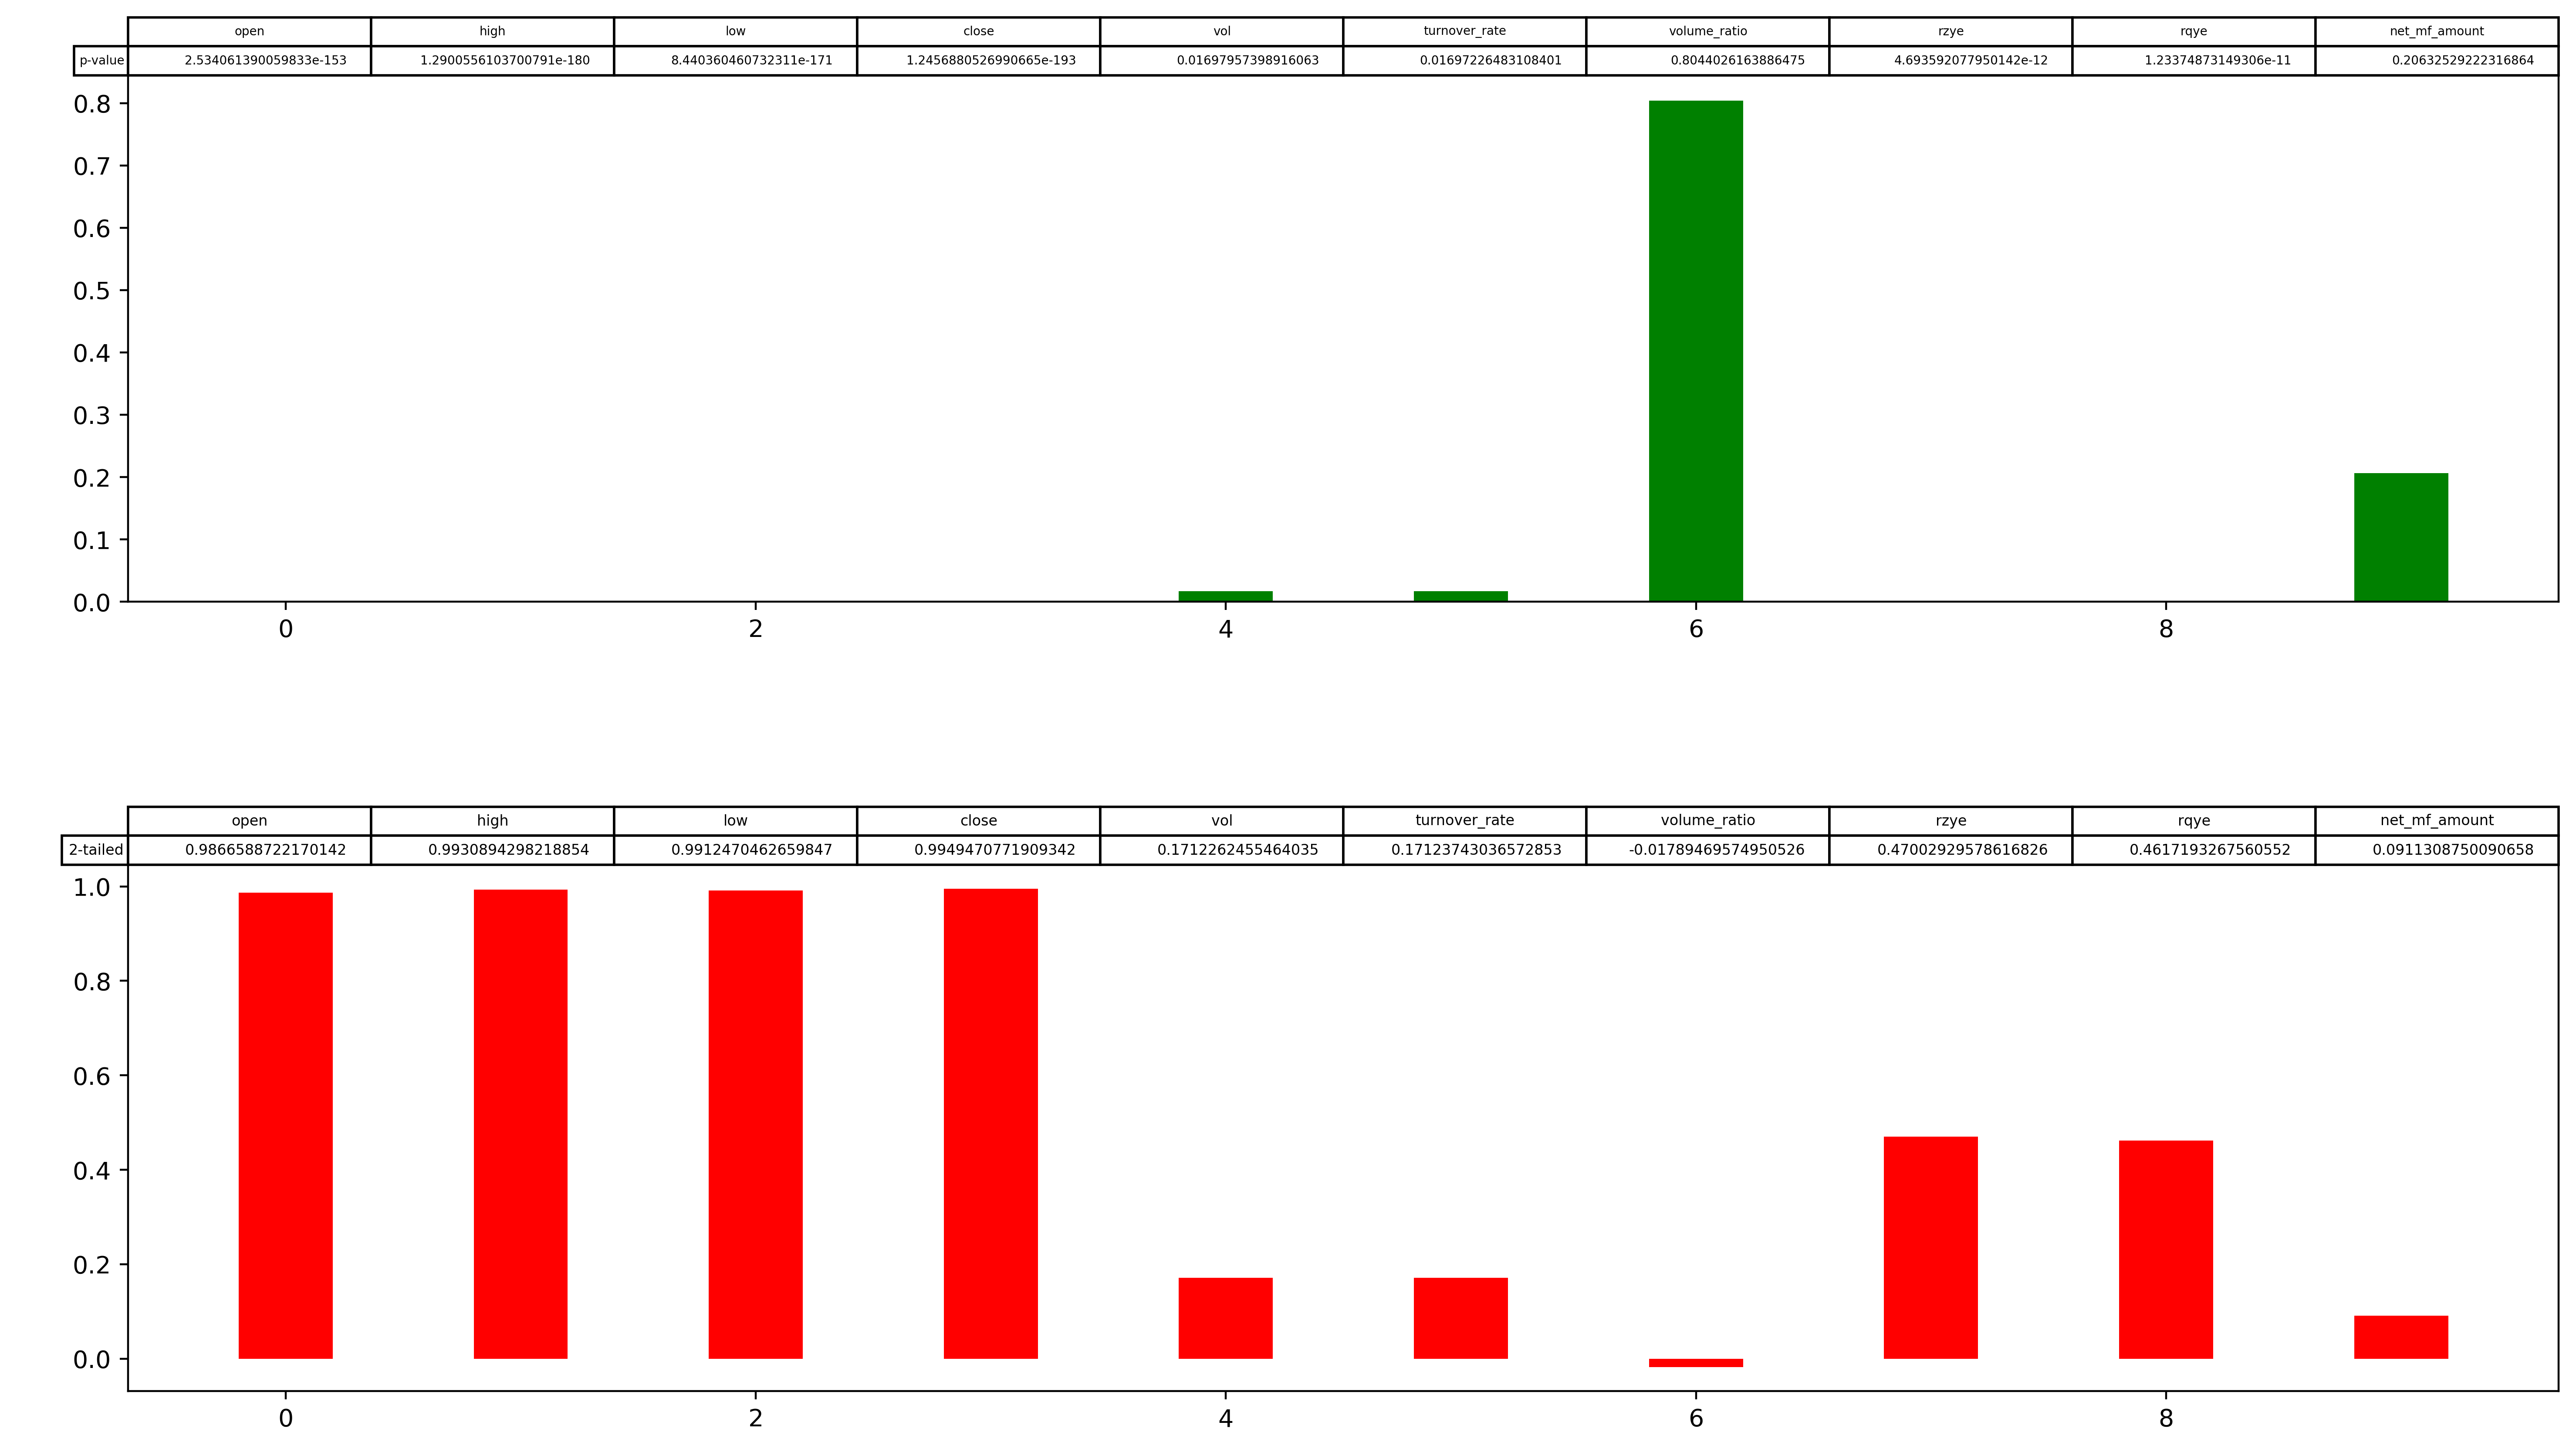

In [29]:
'''
https://www.cnblogs.com/hhh5460/p/5186226.html
皮尔森相关系数是一种最简单的，能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，
1）输入：x为特征，y为目标变量.
2）输出：r： 相关系数 [-1，1]之间，
    结果的取值区间为[-1，1]，-1表示完全的负相关(这个变量下降，那个就会上升)，+1表示完全的正相关，0表示没有线性相关。
 p-value: p值。
    p值越小，表示相关系数越显著，一般p值在500个样本以上时有较高的可靠性。
 
Pearson Correlation速度快、易于计算，经常在拿到数据(经过清洗和特征提取之后的)之后第一时间就执行。
Scipy的pearsonr方法能够同时计算相关系数和p-value，
'''
from scipy.stats import pearsonr

#print(df1.columns)
df_sub = df1.drop(['ts_code','trade_date'],axis=1)

_c = []
_s = []
for c in df_sub.columns:
    #print(c)
    s = pearsonr(X_train[:][c],y_train)
    _c.append(s[0])
    _s.append(s[1])
    #print("%s: %s" %(c,s))
    
data = {'2-tailed':_c,'p-value':_s}  
_df = pd.DataFrame(data,index=df_sub.columns)
print(_df)

x = np.arange(len(_df.index))
y = _df['p-value'] 
z = _df['2-tailed']

fig, axs = plt.subplots(2, 1, figsize=(18, 10),dpi=400)
fig.subplots_adjust(hspace=0.5)

axs[0].bar(x,y,color='green',width=0.4,label='p-value')
_cell = np.vstack((y.values)) #np.narray 转换为2d
_table1 = axs[0].table(cellText=_cell.T,rowLabels=['p-value'],colLabels=_df.index.values,loc='top',fontsize='14')

axs[1].bar(x,z,color='red',width=0.4,label='2-tailed')
_z_cell = np.vstack((z.values)) #np.narray 转换为2d
_table2 = axs[1].table(cellText=_z_cell.T,rowLabels=['2-tailed'],colLabels=_df.index.values,loc='top',fontsize='14')


plt.show()

In [18]:
import akshare as ak
macro_bank_usa_interest_rate_se = ak.macro_bank_usa_interest_rate()
print(macro_bank_usa_interest_rate_se)
print(macro_bank_usa_interest_rate_se.name)

1982-09-27    10.25
1982-10-01    10.00
1982-10-07     9.50
1982-11-19     9.00
1982-12-14     8.50
              ...  
2020-07-30     0.25
2020-09-17     0.00
2020-11-06     0.25
2020-12-17     0.00
2021-01-28     0.25
Name: usa_interest_rate, Length: 257, dtype: float64
usa_interest_rate
